**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

In [4]:
# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=3, cluster_std=[1.7,1.8,1.6] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(10000, 3) (10000,)


In [6]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

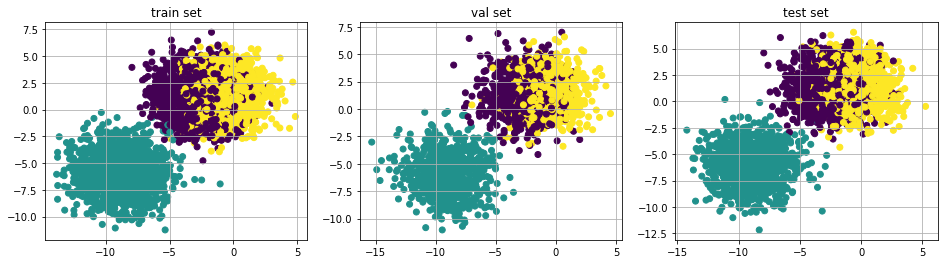

In [7]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [8]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## SLP + MSQE + GD

In [9]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

y_train.shape,y_val.shape,y_test.shape

((4489, 3), (2211, 3), (3300, 3))

In [10]:
y_train[:3,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [11]:
y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(array([1489., 1515., 1485.]),
 array([749., 733., 729.]),
 array([1096., 1085., 1119.]))

In [12]:
from lib.model.linear import SLP
# from lib.initiator.linear import NormalInitiatorLinearModel
from lib.initiator.linear import UniformInitiatorLinearModel

%xdel model

model = SLP(
    initiator=UniformInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        high=.001,
    )
)

model.weight.shape

NameError: name 'model' is not defined


(3, 3)

In [13]:
from lib.loss.msqe import MSQE
loss_train = MSQE(model)
loss_val = MSQE(model)

---

In [14]:
from lib.optimizer.gd import GD 
from lib.optimizer.lrate import ConstLRA 

lra = ConstLRA(.1)

model = GD( 
    loss=loss_train, 
    loss_val=loss_val, 
    lra=lra,
).fit( 
    data_train=[X_train,y_train], 
    data_val=[X_val,y_val], 
    n_epoch=20,
)

100%|██████████| 20/20 [00:00<00:00, 593.51it/s, loss=0.745, lr=0.1]


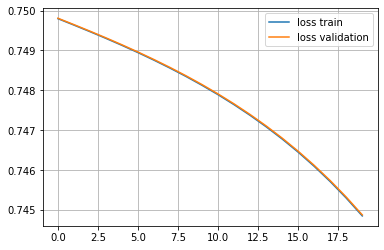

In [15]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

predict is argmax output score vector
              precision    recall  f1-score   support

           0       0.24      0.00      0.01      1096
           1       0.43      1.00      0.60      1085
           2       0.78      0.54      0.64      1119

    accuracy                           0.51      3300
   macro avg       0.48      0.51      0.42      3300
weighted avg       0.49      0.51      0.42      3300



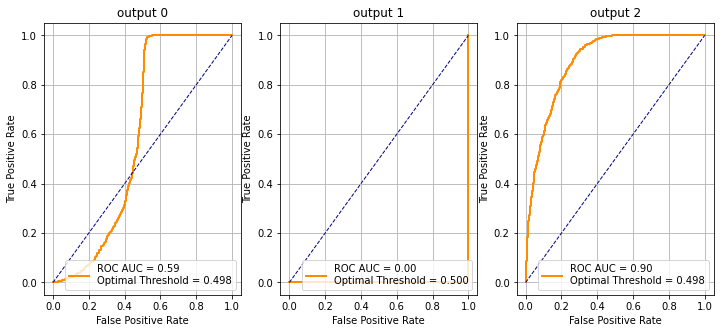

In [16]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

In [17]:
# model.score(X_test)

## Softmax  + CCE + GD

In [18]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {0,+1}

y_train.shape,y_val.shape,y_test.shape

((4489, 3), (2211, 3), (3300, 3))

In [19]:
y_train[:3,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [20]:
y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(array([1489., 1515., 1485.]),
 array([749., 733., 729.]),
 array([1096., 1085., 1119.]))

In [21]:
from lib.model.linear import Softmax 
from lib.initiator.linear import NormalInitiatorLinearModel
# from lib.initiator.linear import UniformInitiatorLinearModel

model = Softmax(
    # initiator=UniformInitiatorLinearModel(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        scale=.1,
    )
)

model.weight.shape

(3, 3)

In [22]:
from lib.loss.cce import CCE # ф-ция потери - категориальная кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

In [32]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import ThresholdBreaking # прерывание по достижению порога значения ф-ции потери
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери
from lib.optimizer.breaker import DifferenceBreaking # прерывание при отсутствии изменения значения ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
#     breaker=[GrowthBreaking(),ThresholdBreaking(2.),DifferenceBreaking()]
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
)

  2%|▏         | 2/100 [00:00<00:00, 299.51it/s, loss=0.714, lr=0.01]

[INFO    ] 2021-10-03 18:03:26 | GrowthBreaking: significant increase in the loss function has been detected


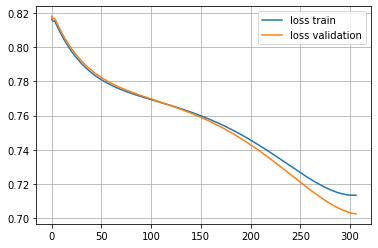

In [33]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

predict is argmax output score vector
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1096
           1       0.66      1.00      0.80      1085
           2       0.85      0.37      0.52      1119

    accuracy                           0.66      3300
   macro avg       0.69      0.66      0.63      3300
weighted avg       0.69      0.66      0.63      3300



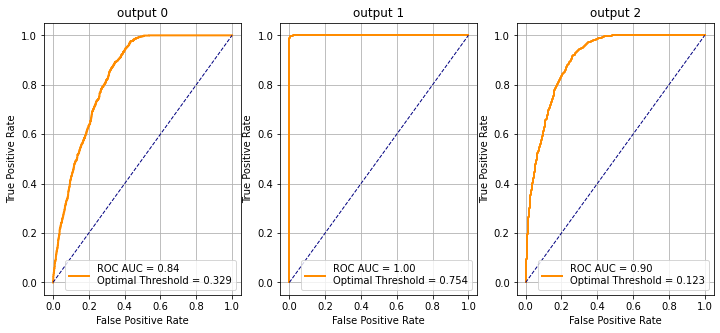

In [34]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

In [35]:
# # (model.predict(X_test) == target_test).sum()/len(target_test)
# (model.predict(X_test) != target_test).sum()/len(target_test)
model.score(X_test)

array([[6.85666506e-02, 9.30453091e-01, 9.80258593e-04],
       [7.05110047e-01, 1.96034130e-01, 9.88558224e-02],
       [2.13030610e-02, 9.78570594e-01, 1.26344597e-04],
       ...,
       [3.93562139e-01, 3.39133612e-01, 2.67304249e-01],
       [1.76501380e-01, 4.23035843e-02, 7.81195036e-01],
       [4.31517827e-02, 9.56340821e-01, 5.07396597e-04]])